In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import cv2
import glob
import sys
import shutil
import random
import os
from os.path import join, isfile

path = "datasets/catsvsdogs/images/"

file_name = [join(path,f) for f in os.listdir(path) if f.endswith((".jpg",".png"))]

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!nvidia-smi

Thu Feb 13 14:59:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 571.96                 Driver Version: 571.96         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 ...  WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   44C    P8              4W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!nvidia-smi

Sat Feb  8 20:43:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 ...  WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   43C    P8              4W /   35W |    2297MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
dog_files = glob.glob(path+"dog*.jpg") #1501
cat_files = glob.glob(path+"cat*.jpg") #1501

os.makedirs("datasets/catsvsdogs/Train",exist_ok=True)
os.makedirs("datasets/catsvsdogs/Train/Dog",exist_ok=True)
os.makedirs("datasets/catsvsdogs/Train/Cat",exist_ok=True)
os.makedirs("datasets/catsvsdogs/Test",exist_ok=True)
os.makedirs("datasets/catsvsdogs/Test/Dog",exist_ok=True)
os.makedirs("datasets/catsvsdogs/Test/Cat",exist_ok=True)

In [5]:
# trainig samples 1400
random.seed(21)
train_dog_samples = random.sample(dog_files,1400)
train_cat_samples = random.sample(cat_files,1400)

In [4]:

# **Note**
# code below seperate random unrepetitive data to train and test
# test_dog_samples = []
# test_cat_samples = []
# while len(test_dog_samples) < 100:
#     potential_samples = random.sample(dog_files, min(100, len(dog_files) - len(train_dog_sample) - len(test_dog_samples)))
#     for f in potential_samples:
#         if f not in train_dog_sample and f not in test_dog_samples:
#             test_dog_samples.append(f)
#             if len(test_dog_samples) >= 100:
#                 break
# while len(test_cat_samples) < 100:
#     potential_samples = random.sample(cat_files, min(100, len(cat_files) - len(train_cat_sample) - len(test_cat_samples)))
#     for f in potential_samples:
#         if f not in train_cat_sample and f not in test_cat_samples:
#             test_cat_samples.append(f)
#             if len(test_cat_samples) >= 100:
#                 break

In [6]:

def resizing(img):
    img = cv2.imread(img)
    img = cv2.resize(img,(200,200),interpolation=cv2.INTER_AREA)
    return img

for f in train_dog_samples:
    newf = os.path.basename(f)
    cv2.imwrite("datasets/catsvsdogs/Train/Dog/"+newf,resizing(f))
for f in train_cat_samples:
    newf = os.path.basename(f)
    cv2.imwrite("datasets/catsvsdogs/Train/Cat/"+newf,resizing(f)) 

# testing samples 101
test_cat_samples = [f for f in cat_files if f not in train_cat_samples]
test_dog_samples = [f for f in dog_files if f not in train_dog_samples]

for f in test_cat_samples:
    newf = os.path.basename(f)
    cv2.imwrite("datasets/catsvsdogs/Test/Cat/"+newf,resizing(f)) 
for f in test_dog_samples:
    newf = os.path.basename(f)
    cv2.imwrite("datasets/catsvsdogs/Test/Dog/"+newf,resizing(f)) 

In [7]:
train_labels = []
test_labels = []
train_image_paths = []
test_image_paths = []

for folder, label in [(train_cat_samples, 0), (train_dog_samples, 1)]:  # 1 to dogs, 0 to cats
    for img_file in folder:
        train_image_paths.append(img_file)
        train_labels.append(label)

for folder, label in [(test_cat_samples, 0), (test_dog_samples, 1)]:  # 1 to dogs, 0 to cats
    for img_file in folder:  
        test_image_paths.append(img_file)
        test_labels.append(label)


In [8]:
# visualize images and labels
for i in range(1,11):
    random = np.random.randint(0, len(test_image_paths))
    image = cv2.imread(test_image_paths[random])
    cv2.imshow("image_"+str(i), image)
    if test_labels[random] == 0:
        print(str(i) + " - Cat")
    else:
        print(str(i)+ " - Dog")
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

1 - Dog
2 - Cat
3 - Dog
4 - Cat
5 - Dog
6 - Dog
7 - Dog
8 - Cat
9 - Cat
10 - Cat


In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils # for one hot encoder

In [3]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')      # uses the fill mode nearest to fill gaps created by the above)
test_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory("datasets/catsvsdogs/Train",
                                                    target_size=(200,200),
                                                    batch_size = 16,
                                                    class_mode="binary",
                                                    shuffle = True)

test_generator = test_datagen.flow_from_directory("datasets/catsvsdogs/Test",
                                                    target_size=(200,200),
                                                    batch_size = 16,
                                                    class_mode="binary",
                                                    shuffle = False)

Found 2800 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [4]:
# model architecture
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation="relu",input_shape=(200,200,3)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Only 1 output neuron. 
    # It will contain a value from 0-1 where 0 for 1 dog and 1 for cat
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model1.summary())
#1.7M params
# reached max epochs 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [73]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(200,200,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # Only 1 output neuron. 
    # It will contain a value from 0-1 where 0 for 1 class ('dog') and 1 for the other ('cat')
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model2.summary())
#2.2M params

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 97, 97, 32)       128       
 hNormalization)                                                 
                                                      

In [71]:
#model compilation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

os.makedirs("model_checkpoints",exist_ok=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor = 0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
early_stop = EarlyStopping(monitor="val_loss",
                           patience=5,
                           restore_best_weights=True)
checkpoint = ModelCheckpoint(join("model_checkpoints",'model5.h5'),
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True)

model1.compile(optimizer=Adam(learning_rate=0.001),
              loss="binary_crossentropy",#model1 loss=Adam(learning_rate=0.001) or "rmsprop"
              metrics=["accuracy"])


In [143]:
history = model1.fit(train_generator,
                    validation_data=test_generator,
                    epochs=80,
                    verbose=1,
                    callbacks=[early_stop, checkpoint, reduce_lr])
# start 3.38

Epoch 1/80
175/175 [==============================] - 77s 400ms/step - loss: 0.6978 - accuracy: 0.5118 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 2/80
175/175 [==============================] - 36s 204ms/step - loss: 0.6908 - accuracy: 0.5136 - val_loss: 0.6841 - val_accuracy: 0.5000
Epoch 3/80
175/175 [==============================] - 36s 206ms/step - loss: 0.6854 - accuracy: 0.5525 - val_loss: 0.6623 - val_accuracy: 0.5842
Epoch 4/80
175/175 [==============================] - 36s 208ms/step - loss: 0.6812 - accuracy: 0.5575 - val_loss: 0.6832 - val_accuracy: 0.5693
Epoch 5/80
175/175 [==============================] - 37s 210ms/step - loss: 0.6868 - accuracy: 0.5596 - val_loss: 0.6725 - val_accuracy: 0.6040
Epoch 6/80
175/175 [==============================] - 37s 212ms/step - loss: 0.6755 - accuracy: 0.5825 - val_loss: 0.6349 - val_accuracy: 0.6337
Epoch 7/80
175/175 [==============================] - 35s 198ms/step - loss: 0.6645 - accuracy: 0.6018 - val_loss: 0.6377 - val_ac

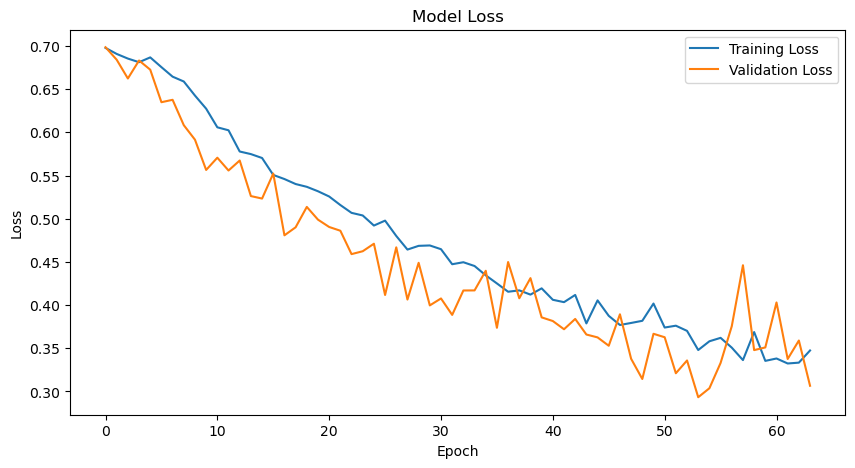

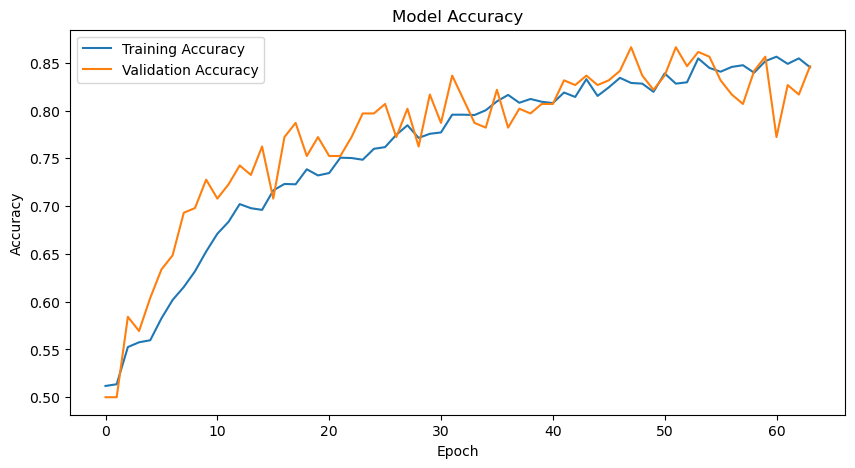

In [144]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [3]:
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join("model_checkpoints", 'model4_86_0.29.h5'))

In [6]:
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 [==============================] - 36s 206ms/step - loss: 0.2934 - accuracy: 0.8614
Test Loss: 0.2933754324913025
Test Accuracy: 0.8613861203193665


<!-- model1 results: by 1000 images
Test Loss: 0.5768921375274658
Test Accuracy: 0.675000011920929 -->

In [6]:
predictions = loaded_model.predict(test_generator)
print(f"Predictions: {predictions}")

13/13 [==============================] - 1s 71ms/step
Predictions: [[1.2168359e-02]
 [6.6126264e-03]
 [1.8520029e-01]
 [1.0547003e-01]
 [3.5798024e-02]
 [3.2696864e-01]
 [1.5320581e-01]
 [6.7115360e-01]
 [7.1277523e-01]
 [1.6784653e-01]
 [2.3320571e-01]
 [1.6783716e-01]
 [5.1730191e-03]
 [2.6686943e-01]
 [7.6830256e-01]
 [1.9356374e-02]
 [2.5791866e-01]
 [4.5902056e-01]
 [4.6172756e-01]
 [6.4501099e-02]
 [1.9133041e-03]
 [2.7034356e-04]
 [1.4188978e-02]
 [6.9090866e-02]
 [3.2103196e-02]
 [5.5777818e-02]
 [4.2568598e-02]
 [8.2922138e-02]
 [7.4324816e-02]
 [2.6300588e-01]
 [3.0476430e-01]
 [8.2634145e-01]
 [1.1662474e-03]
 [4.0429514e-02]
 [2.7599305e-01]
 [5.0809633e-02]
 [3.7050374e-02]
 [3.2144047e-02]
 [5.6506950e-01]
 [7.7347219e-02]
 [4.9186949e-02]
 [1.0314485e-01]
 [8.0296084e-02]
 [4.5554782e-03]
 [2.0780897e-02]
 [2.1363632e-01]
 [6.5844691e-01]
 [2.1991483e-03]
 [4.6170276e-02]
 [7.0025295e-01]
 [1.4797166e-03]
 [7.1528457e-02]
 [7.3830888e-02]
 [1.7676760e-02]
 [2.1394786e-01

# visualizing our test data

In [7]:

def draw_test(name, pred, input_im):
    BLACK = [0, 0, 0]
    pred_label = "cat" if pred <= 0.5 else "dog"
    expanded_image = cv2.copyMakeBorder(input_im, 0, 50, 0, 0, cv2.BORDER_CONSTANT, value=BLACK)
    cv2.putText(expanded_image, pred_label, (10, input_im.shape[0] + 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow(name, expanded_image)

for i in range(10):
    rand = random.randint(0, len(test_image_paths) - 1)
    input_path = test_image_paths[rand]
    imageL = cv2.imread(input_path)
    imageL = cv2.cvtColor(imageL, cv2.COLOR_BGR2RGB)
    imageL_resized = cv2.resize(imageL, (200, 200), interpolation=cv2.INTER_CUBIC)
    input_im = np.expand_dims(imageL_resized, axis=0) / 255.0  # Normalize the image

    res = loaded_model.predict(input_im)

    draw_test("Prediction", res, imageL)
    cv2.waitKey(0)

cv2.destroyAllWindows()


NameError: name 'test_image_paths' is not defined

# visualizing missclassification

In [47]:
np_preds = predictions.reshape(202,)

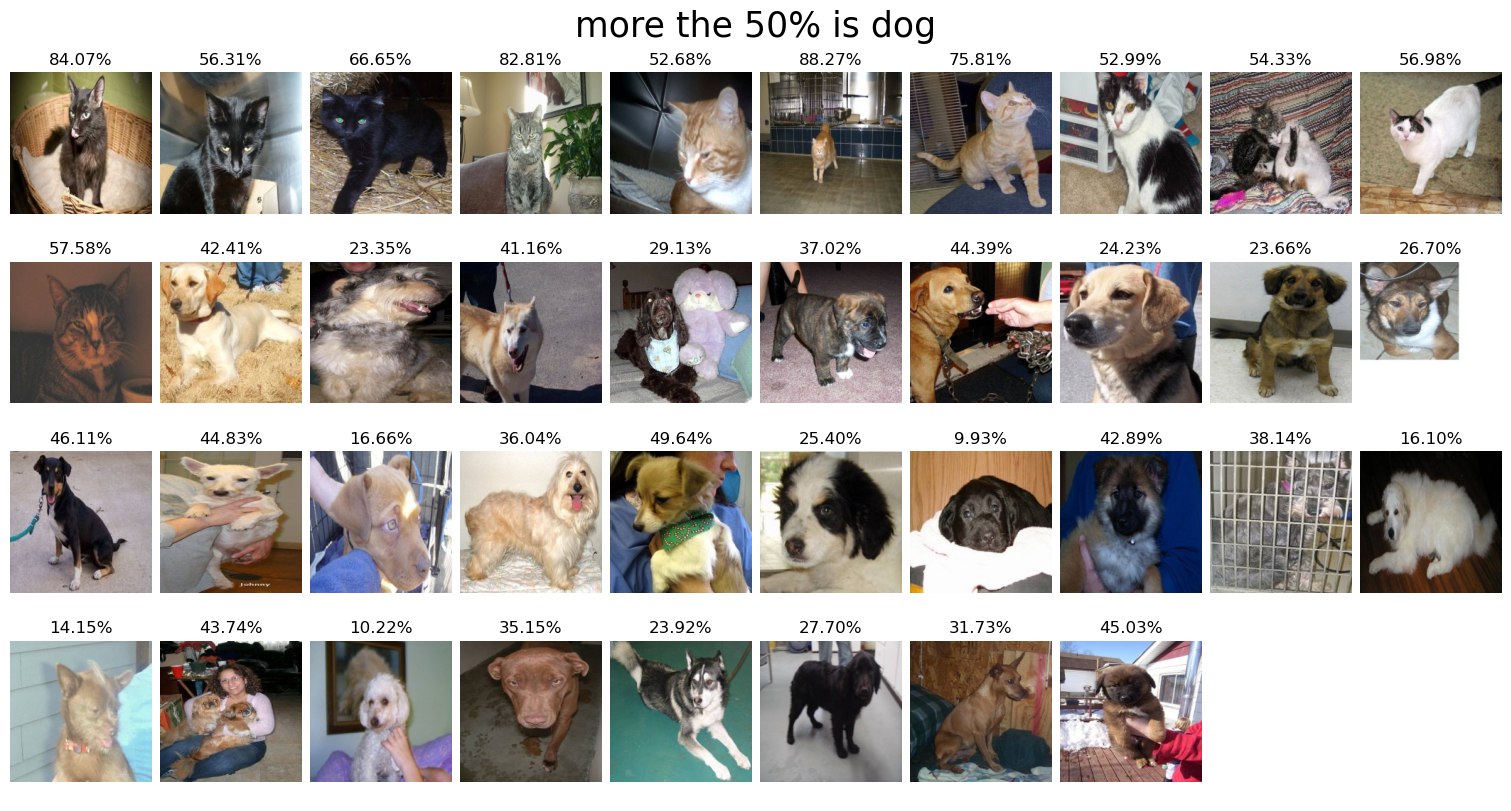

In [137]:
num_images = len(wrongs[0])
num_cols = 10
num_rows = (num_images + num_cols - 1) // num_cols
def ploting(num_rows,num_cols,preds,img)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 2), constrained_layout=True)
fig.suptitle("more the 50% is dog",fontsize=25)
for i in range(num_images):
    wrong = wrongs[0][i]
    img = cv2.imread(test_generator.filepaths[wrong])
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f"{np_preds[wrong] * 100:.2f}%")
    axes[row, col].axis("off")

for j in range(num_images, num_rows * num_cols):
    row = j // num_cols
    col = j % num_cols
    axes[row, col].axis("off")

plt.show()
cv2.destroyAllWindows()


# testing from real sources

1/1 [==============================] - 0s 31ms/step


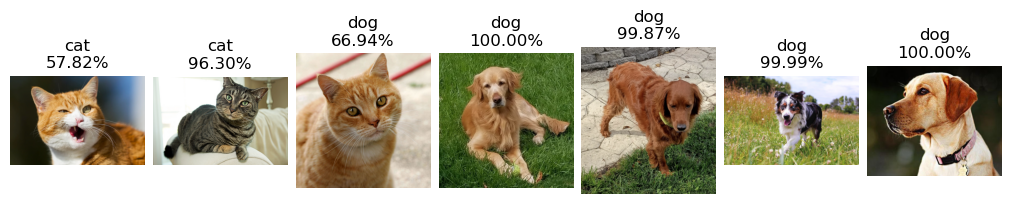

In [77]:
input_path = "datasets/catsvsdogs/real_imgs/"
img_numbers = [i for i in os.listdir(input_path) if i.endswith((".jpg",".png",".webp"))]
fig, axes = plt.subplots(ncols=len(img_numbers),figsize=(10,10),constrained_layout=True)


def draw_real(No, preds, image):   
    
    axes[No].imshow(image)
    if preds[0][0]< 0.5:
        name = "cat"
        accuracy = 100 - preds[0][0]*100
    else:
        name = "dog"
        accuracy = preds[0][0]*100
    axes[No].set_title(f"{name}\n{accuracy:.2f}%")
    axes[No].axis("off")

for No, i  in enumerate( img_numbers):
    imageL = cv2.imread(input_path+i)
    imageL = cv2.cvtColor(imageL, cv2.COLOR_BGR2RGB)
    imageL_resized = cv2.resize(imageL, (200, 200), interpolation=cv2.INTER_CUBIC)
    input_im = np.expand_dims(imageL_resized, axis=0) / 255.0  # Normalize the image
    res = loaded_model.predict(input_im)
    draw_real(No, res, imageL)
    
    
plt.show()
cv2.destroyAllWindows()

# using pre trained model

In [97]:
import keras
from keras.applications.resnet import ResNet50
from keras.preprocessing import image

In [133]:
from keras.applications.resnet import preprocess_input, decode_predictions
modelresnet50 = ResNet50(weights='imagenet')
img_path = 'datasets/catsvsdogs/real_imgs/2AE14CDD-1265-470C-9B15F49024186C10_source.webp'
img = keras.utils.load_img(img_path, target_size=(224, 224))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = modelresnet50.predict(x)
res = decode_predictions(preds, top=1)

print('Predicted:', decode_predictions(preds, top=1))

1/1 [==============================] - 2s 2s/step
Predicted: [[('n02123159', 'tiger_cat', 0.44433522)]]
0.44433522


1/1 [==============================] - 0s 56ms/step


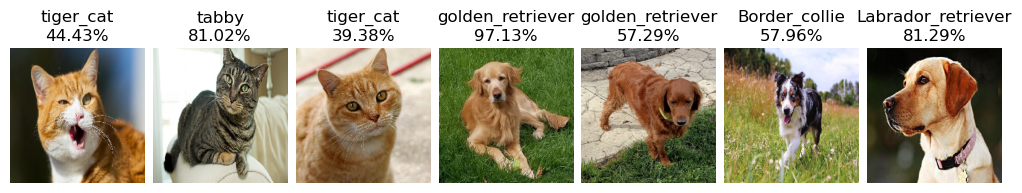

In [137]:
fig, axes = plt.subplots(ncols=len(img_numbers),figsize=(10,10),constrained_layout=True)

# **Note** we should use keras image loader for correct restnet50 working

for No, i  in enumerate( img_numbers):
    
    img = keras.utils.load_img(input_path+i, target_size=(224, 224))
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = modelresnet50.predict(x)
    res = decode_predictions(preds, top=1)

    axes[No].imshow(img)
    name = res[0][0][1]
    accuracy = res[0][0][2]*100
    axes[No].set_title(f"{name}\n{accuracy:.2f}%")
    axes[No].axis("off")

plt.show()
cv2.destroyAllWindows()